In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# Evaluation metrics
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

# Import SpaLP modules    Python package: https://github.com/dbjzs/SpaLP
from SpaLP.LP import SpatialLocalPooling
from SpaLP.utils import set_seed, prepare_inputs
# Set random seed
set_seed(7)

#Check the GPU memory and CPU memory
import memory_profiler  # pip install memory_profiler
import torch
import gc

# Check device
import cpuinfo   # pip install py-cpuinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
info = cpuinfo.get_cpu_info()
print("CPU:", info['brand_raw'])

Using device: cuda
GPU: NVIDIA A800-SXM4-80GB
CPU: Intel(R) Xeon(R) Platinum 8462Y+


In [2]:
#Check the GPU memory and CPU memory
from memory_profiler import memory_usage
def measure_resources(func):
    def wrapper(*args, **kwargs):
        gc.collect()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        before = memory_usage(-1, interval=0.1, timeout=1)[0]
        mem_peak, result = memory_usage((func, args, kwargs),max_usage=True,retval=True)
        print(f"CPU peak memory: {(mem_peak - before)/1024:.2f} GB")
        
        torch.cuda.synchronize()
        gpu_peak = torch.cuda.max_memory_allocated() / 1024**3
        print(f"GPU peak memory: {gpu_peak:.2f} GB")
        return result
    return wrapper

In [3]:
def train_spalp(graph, in_channels, hidden_dim, epochs, lr, device,seed):
    """Train SpaLP model and return embeddings."""
    from tqdm.auto import tqdm
    set_seed(seed)
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    model = SpatialLocalPooling(in_channels, hidden_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    losses = []
    
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})
    
    # Get final embeddings
    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        reconstructed = reconstructed.cpu().numpy()
        embedding=embedding.cpu().numpy()
    return embedding, losses

# Dataset 1: Xenium Million Mouse Tissue (1.35M cells)

In [4]:
# Load Million Mouse Tissue data
adata = sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/Million_Mouse_Tissue.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 1,355,849 cells x 379 genes
obsm keys: ['spatial']


In [5]:
adata

AnnData object with n_obs × n_vars = 1355849 × 379
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [6]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (1355849, 2)
Preprocessing standardization: 4.01s


In [7]:
# Set the hyperparameters  k=3
k=3
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 379


In [8]:
# Build neighbor graph  k=3
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 1.03s


In [9]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.16it/s, Epoch=199, Loss=0.6955]


CPU peak memory: 2.49 GB
GPU peak memory: 15.80 GB
Training time: 50.90s
CPU times: user 48.3 s, sys: 1.67 s, total: 50 s
Wall time: 50.9 s


In [10]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.765, random_state=2024, key_added="SpaLP") #The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Leiden time: 89min 34.79s
UMAP time: 16min 52.52s
Found 41 clusters
CPU times: user 5h 47min 43s, sys: 2h 30min 22s, total: 8h 18min 5s
Wall time: 1h 46min 27s


In [12]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 3min 31s, sys: 6min 50s, total: 10min 22s
Wall time: 10.8 s


In [13]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig3Million_Mouse_Tissue.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis.

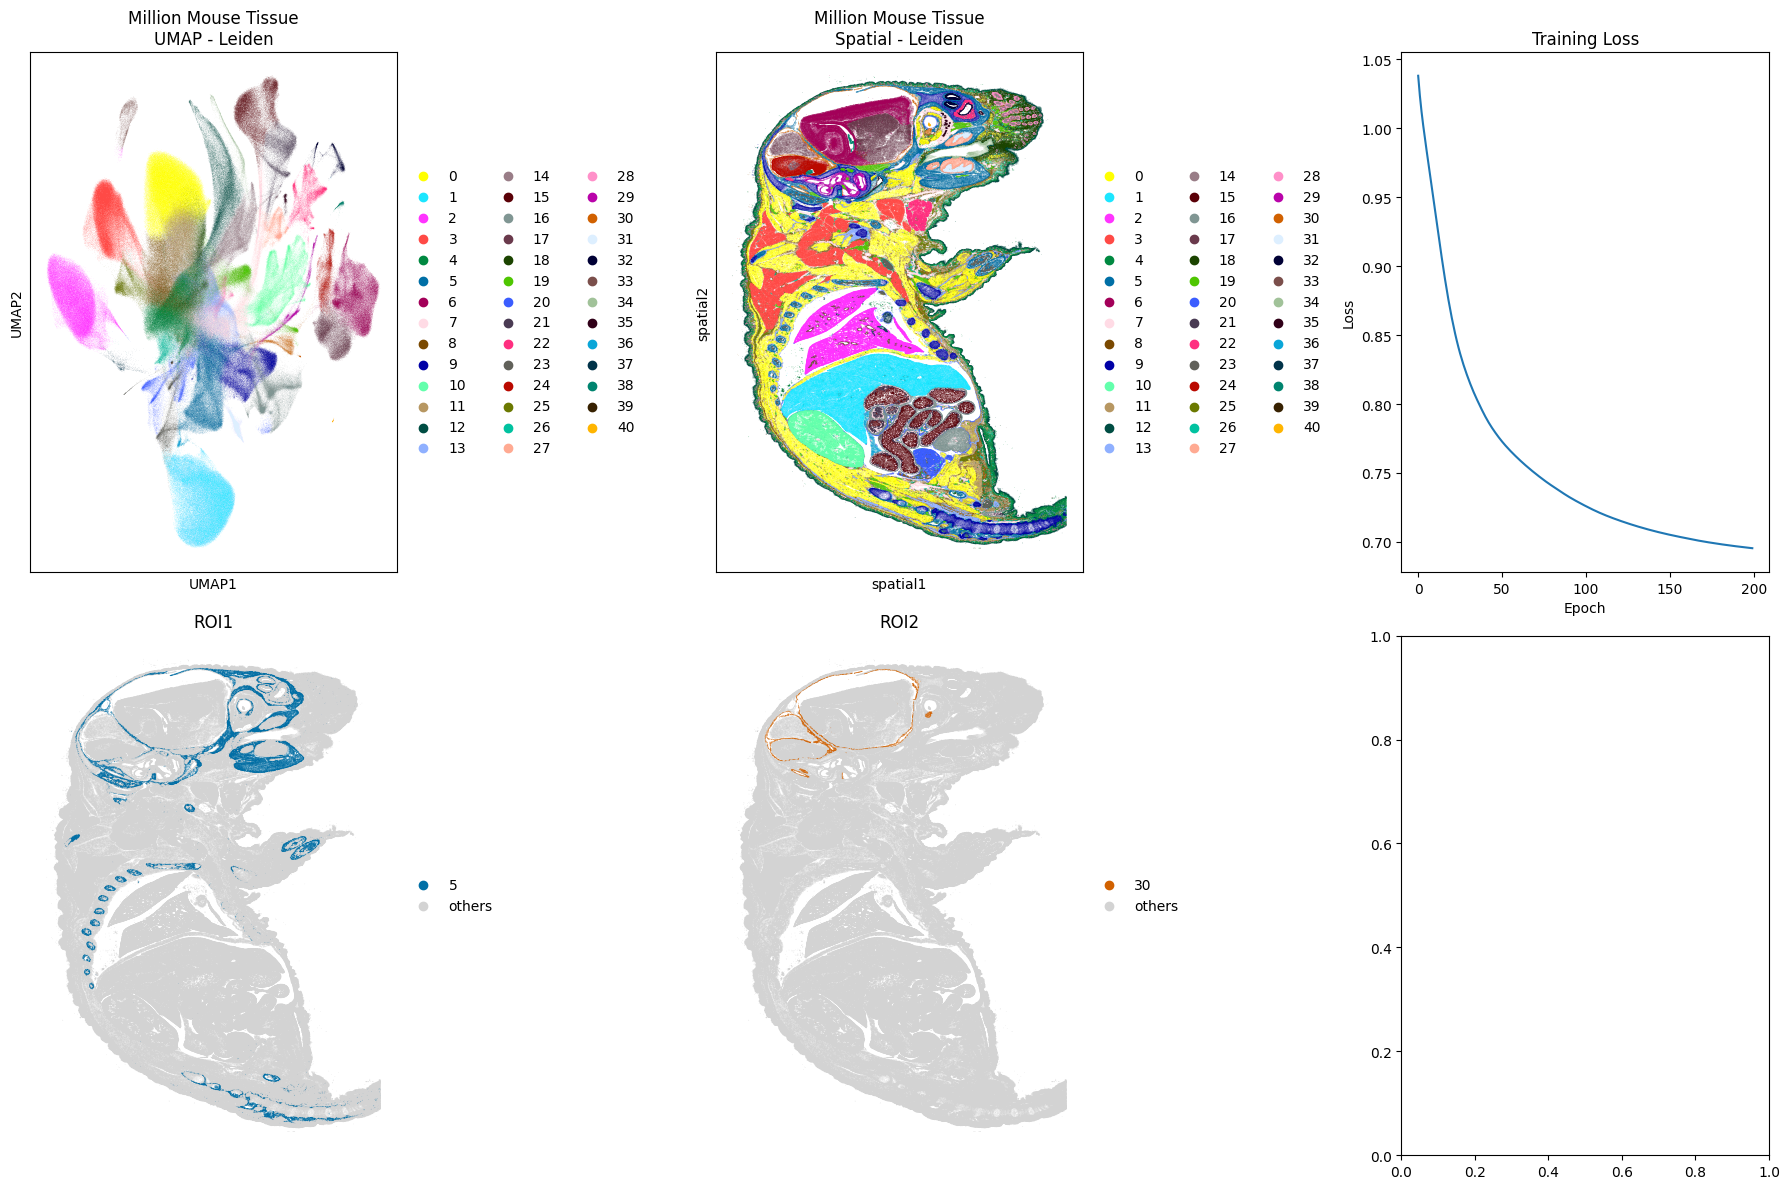

In [15]:
# Visualization
adata.obsm['spatial'][:, 0] = -adata.obsm['spatial'][:, 0]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# UMAP with legend
sc.pl.umap(adata, color='SpaLP', ax=axes[0, 0], show=False, title='Million Mouse Tissue\nUMAP - Leiden', legend_loc='right margin')

# Spatial with legend using scanpy
sc.pl.embedding(adata, basis='spatial', color='SpaLP', ax=axes[0, 1], show=False, title='Million Mouse Tissue\nSpatial - Leiden', s=0.5, alpha=0.7, legend_loc='right margin')

# Training loss
axes[0, 2].plot(losses)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].set_title('Training Loss')

orig_colors = adata.uns["SpaLP_colors"]

#Cluster highlight
highlight_clusters = {5: "ROI1",30: "ROI2"}

for col, (cluster_id, title) in enumerate(highlight_clusters.items()):
    highlight_color = orig_colors[cluster_id]

    adata.obs["SpaLP_highlight"] = np.where(adata.obs["SpaLP"].astype(str) == str(cluster_id),str(cluster_id),"others")
    sc.pl.embedding(adata,basis="spatial",color="SpaLP_highlight",palette={str(cluster_id): highlight_color, "others": "lightgrey"},ax=axes[1, col],show=False,s=0.5,frameon=False,title=title)

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig3/Fig3_Million_Mouse_Tissue.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 2: Stereo-seq testicle

In [16]:
#Load Stereo-seq testicle data
adata=sc.read_h5ad('/home/dbj/SpaLA/stereoseqmousegaowan/testis.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 198,248 cells x 27,869 genes
obsm keys: ['cell_border', 'spatial']


In [17]:
adata

AnnData object with n_obs × n_vars = 198248 × 27869
    obs: 'dnbCount', 'area', 'id', 'orig.ident', 'x', 'y'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

In [18]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]

sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (198248, 2)
Preprocessing standardization: 10.23s


In [19]:
# Set the hyperparameters  k=4
k=4
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=50
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 5000


In [20]:
# Build neighbor graph  k=3
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 1.09s


In [21]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.28it/s, Epoch=199, Loss=0.9882]


CPU peak memory: 3.65 GB
GPU peak memory: 19.60 GB
Training time: 28.63s
CPU times: user 25.1 s, sys: 2.33 s, total: 27.4 s
Wall time: 28.6 s


In [22]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=1.2, random_state=2024, key_added="SpaLP") #The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 7min 13.02s
UMAP time: 1min 44.36s
Found 17 clusters
CPU times: user 19min 48s, sys: 8min 32s, total: 28min 20s
Wall time: 8min 57s


In [23]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)   #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 10.1 s, sys: 10.7 s, total: 20.7 s
Wall time: 602 ms


In [24]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig3Mouse_testicles.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis.

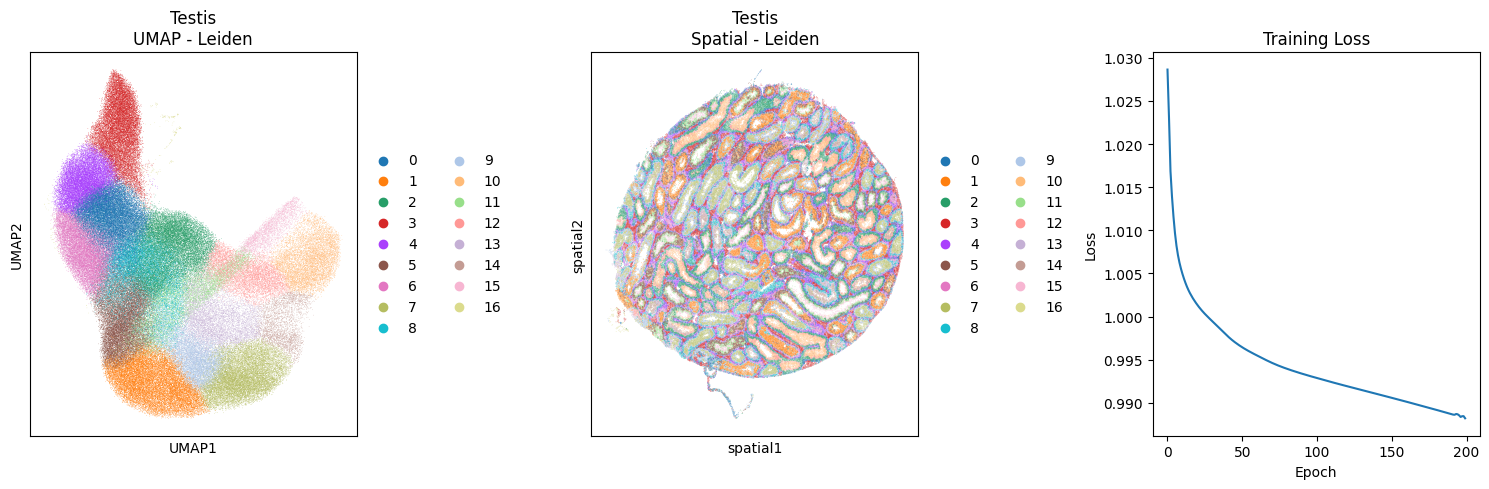

In [27]:
# Visualization
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# UMAP with legend
sc.pl.umap(adata, color='SpaLP', ax=axes[0], show=False, title='Testis\nUMAP - Leiden', legend_loc='right margin')

# Spatial with legend using scanpy
sc.pl.embedding(adata, basis='spatial', color='SpaLP', ax=axes[1], show=False, title='Testis\nSpatial - Leiden', s=1, alpha=0.7, legend_loc='right margin')

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig3/Fig3_Mouse_testicles.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 3:Stereo_CITE-seq (295K cells, 128 proteins)

In [28]:
#Load Stereo-CITE-seq data
adata=sc.read_h5ad('/home/dbj/SpaLA/stereoseq/Stereo_CITE-seq.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} proteins")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 295,215 cells x 128 proteins
obsm keys: ['cell_border', 'spatial']


In [29]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (295215, 2)
Preprocessing standardization: 0.67s


In [30]:
# Set the hyperparameters  k=4
k=4
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 128


In [31]:
# Build neighbor graph  k=4
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.17s


In [32]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.74it/s, Epoch=199, Loss=0.8720]


CPU peak memory: 0.11 GB
GPU peak memory: 4.04 GB
Training time: 15.83s
CPU times: user 13.7 s, sys: 1.04 s, total: 14.7 s
Wall time: 15.8 s


In [33]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.3, key_added="SpaLP") #The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Leiden time: 10min 45.43s
UMAP time: 2min 34.21s
Found 7 clusters
CPU times: user 30min 15s, sys: 15min 41s, total: 45min 56s
Wall time: 13min 19s


In [34]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)   #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 13.3 s, sys: 13.8 s, total: 27.1 s
Wall time: 744 ms


In [35]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig3CITE-seq_mouse_spleen.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis.

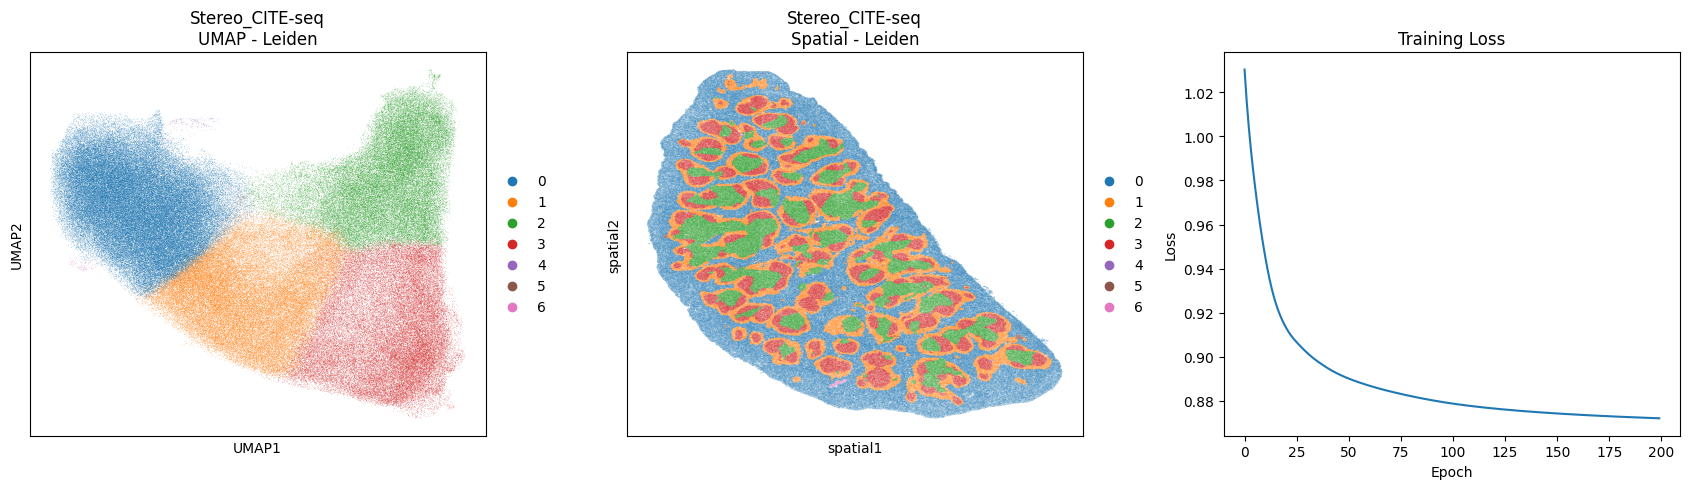

In [36]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
# UMAP with legend
sc.pl.umap(adata, color='SpaLP', ax=axes[0], show=False, title='Stereo_CITE-seq\nUMAP - Leiden', legend_loc='right margin')

# Spatial with legend using scanpy
sc.pl.embedding(adata, basis='spatial', color='SpaLP', ax=axes[1], show=False, title='Stereo_CITE-seq\nSpatial - Leiden', s=1, alpha=0.7, legend_loc='right margin')

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig3/Fig3CITE-seq_mouse_spleen.png', dpi=150, bbox_inches='tight')
plt.show()